In [74]:
import numpy as np

def estimador_potencia(V, X, X_SH, L, M, Pn, S, NEF, gamma_sh):
    
    # Expresamos las potencias en veces

    S= 10**((S-30)/10)
    Pn= 10**((Pn-30)/10)

    # Estimador de potencia de la señal con correlación

    S_corr= 0
    for i in range(L):
        for j in range(M):
            S_corr += 1/(M*L) * np.absolute(V[i,j])**2 
    S_corr= S_corr - Pn

    # Estimador de potencia de la señal blanqueada

    S_W= 0
    for i in range(L):
        for j in range(M):
            S_W += 1/(M*L) * np.absolute(X[i,j])**2 

    S_W = S_W - Pn*NEF

    # Estimador de potencia señal pseudoblanqueada

    S_SH= 0
    for i in range(L):
        for j in range(M):
            S_SH += 1/(M*L) * np.absolute(X_SH[i,j])**2 

    S_SH = S_SH - Pn*gamma_sh

    
    return(S_corr, S_W, S_SH)

    

In [75]:
import numpy as np

def estimador_vel_dop(X, L, M, v_amax):
    
    # Estimador de autocorrelación en lag=1 señal con correlación

    Rx_1= np.zeros(1, dtype= 'complex_') 
    for j in range(L):
        for i in range(M-1):
             Rx_1 += 1/(L*(M-1)) *np.conjugate(X[j,i])*X[j,i+1]

    # Estimador de velocidad Doppler señal con correlación
    
    v_dop = -v_amax/np.pi * np.arctan2(Rx_1.imag, Rx_1.real)
   
    return(v_dop, Rx_1)




In [76]:
import numpy as np

def estimador_ancho_Doppler(v_amax, S_est, Rx_1):
    
    # Estimador del ancho de banda Doppler señal con correlación

    sig_doppler= v_amax*np.sqrt(2)/np.pi * np.sqrt(np.abs(np.log(S_est/np.abs(Rx_1)))) * np.sign(np.log(S_est/np.abs(Rx_1)))

    return(sig_doppler)

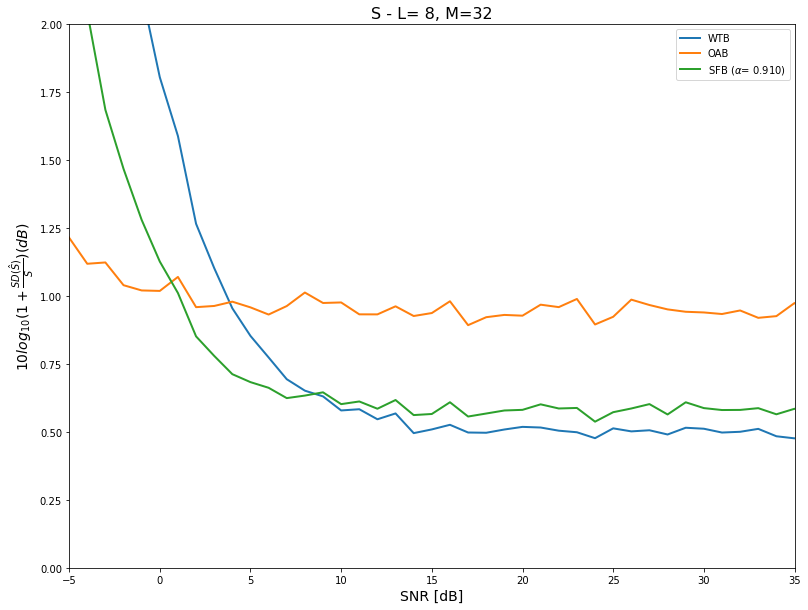

In [77]:
# RELEVAMIENTO DE CURVAS DE DESVIACIONES ESTANDAR


import numpy as np
from datos_sinteticos import datos_sinteticos
from blanqueo import blanqueo
from sharpering_filter import sharpering_filter
from matplotlib import pyplot as plt 

# Generamos la señal de radar con el simulador 

L= 8  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 32 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 10 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 2 # Ancho de banda Doppler, en m/s
v_amax = 13.33 # Max velocidad ambigüa, en m/s
v_mean = 5 # Velocidad Doppler media, en m/s
lamb= 0.0536 # Frecuencia de operanción, en m 

o= 50 # para relevar de -10 a 40 SNR
cant= 1000 # Cantidad de iteraciones para calcular las desviaciones

S_W_vector= np.zeros((o, cant),dtype = 'complex_')
S_cor_vector= np.zeros((o, cant),dtype = 'complex_')
s_sh_vector= np.zeros((o, cant),dtype = 'complex_')
for i in range(o):
    
    for j in range(cant):

        Pn= -30 + i
        
        # Datos sintetizados

        V= datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax)
        
        # Datos blanqueados

        X, C_v= blanqueo(V, L, p_l, h_l)

        NEF= NEF= 1/L * np.trace(np.linalg.inv(C_v)) 

        alpha_1= 0.91 # Factor de pseudoblanqueo 

        X_SH_1, gamma_sh_1= sharpering_filter(V, L, C_v, alpha_1)

        S_cor_vector[i,j], S_W_vector[i,j], s_sh_vector[i,j] = estimador_potencia(V, X, X_SH_1, L, M, Pn, S, NEF, gamma_sh_1)

# Desviación standar de los estimadores de potencia para la señal blaqueada y correlacionada

Sd_S_W= np.zeros(o)
Sd_S_corr= np.zeros(o)
Sd_S_sh= np.zeros(o)


for i in range(o):
    Sd_S_W[i]= np.std(S_W_vector[i,:])
    Sd_S_corr[i]= np.std(S_cor_vector[i,:])
    Sd_S_sh[i]= np.std(s_sh_vector[i,:])
    
Sd_S_cor_norm=0
Sd_S_W_norm= 0
Sd_S_sh_norm= 0
Sd_S_W_norm= Sd_S_W[::-1] / (10**((S-30)/10))
Sd_S_cor_norm= Sd_S_corr[::-1] / (10**((S-30)/10))
Sd_S_sh_norm= Sd_S_sh[::-1] / (10**((S-30)/10))

# Gráficas 

SNR= np.arange(-10,40)


plt.figure(1, figsize=(13,10))
plt.plot(SNR, 10*np.log10(1+Sd_S_W_norm), label='WTB',linewidth=2)
plt.plot(SNR, 10*np.log10(1+Sd_S_cor_norm), label='OAB',linewidth=2)
plt.plot(SNR, 10*np.log10(1+Sd_S_sh_norm), label=r'SFB ($\alpha$= %.3f)' %alpha_1,linewidth=2)
plt.xlabel('SNR [dB]', fontdict= {'size': 14})
plt.xlim(-5,35)
plt.ylim(0,2)
plt.ylabel(r'$10log_{10}(1+\frac{SD(\hat{S})}{S})(dB)$', fontdict= {'size': 14})
plt.title("S - L= %d, M=%d" %(L,M), fontdict= {'size': 16} )
plt.legend()


